In this notebook, we will be working through [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I) by Andrej Karpathy. This is the third video in the "Neural Networks: Zero to Hero" series.

Where the previous video built a **bigram** character-level language model (predicting the next character from only the _previous_ character), this video takes a massive leap: we implement the core ideas from Bengio et al. 2003 — ["A Neural Probabilistic Language Model"](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) — one of the most influential papers in NLP history.

**The key idea:** Instead of conditioning on just one previous character, we use a **fixed-size context window** (e.g., the previous 3 characters) and feed them through a neural network (MLP) to predict the next character. This is a fundamentally different approach from counting bigrams:

1. **Learned embeddings** — each character gets a dense vector representation (not a one-hot), and similar characters end up nearby in embedding space. This is the same idea behind `nn.Embedding` in PyTorch and the token embeddings in every modern transformer.
2. **Shared statistical strength** — because the model operates on embeddings rather than raw character identities, it can generalize: if it learns that `da` is a common pattern, it can partially transfer that knowledge to `do` because `a` and `o` might be nearby in embedding space (both vowels).
3. **Multi-character context** — by looking at 3 characters instead of 1, the model can learn much richer patterns about which character sequences are plausible in English names.

**Connection to modern transformers:** The architecture we build here — embedding lookup → concatenation → hidden layer → output distribution — is essentially the "embedding + MLP head" that appears in every transformer. Transformers replace the fixed context window with self-attention (allowing variable-length context), but the embedding layer and the final prediction head work exactly the same way. Bengio 2003 laid the conceptual foundation that GPT, BERT, and every modern LLM builds on.

We'll still be using our trusty `names.txt` dataset — 32K names, character-level, predicting the next character autoregressively.


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Section 1: Dataset & Character Mappings

We load the same `names.txt` dataset from lesson 2 and build the same character-to-integer mappings. Our vocabulary is 27 characters: the special token `.` (index 0) representing both start and end of a name, plus the 26 lowercase letters `a`-`z` (indices 1-26).

These mappings (`stoi` and `itos`) are used throughout the notebook — every time we need to convert between human-readable characters and the integer indices that tensors require.


In [2]:
# utility to read dataset
DATASET_PATH = './names.txt'
SPECIAL_TOKEN = "."

def get_dataset():
    with open(DATASET_PATH, 'r') as f:
        rows = [row.strip() for row in f.readlines()]
    return rows

In [3]:
# Load dataset
words = get_dataset()
print(f"{len(words)} names loaded")
print(f"Examples: {words[:8]}")

# Build character mappings — identical to lesson 2
# '.' is our special start/end token at index 0, then a=1, b=2, ..., z=26
all_characters = [SPECIAL_TOKEN] + sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(all_characters)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"Vocabulary size: {vocab_size}")
print(f"Mappings: {itos}")

32033 names loaded
Examples: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Vocabulary size: 27
Mappings: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


# Section 2: Building the Dataset

This is where the MLP approach fundamentally differs from bigrams. Instead of looking at just one previous character, we use a **sliding window** of `block_size` characters as context to predict the next character.

With `block_size=3`, the context window slides across each name like this. Take the name `emma`:

| Context (X) | Target (Y) | Meaning                                    |
| :---------: | :--------: | :----------------------------------------- |
|    `...`    |    `e`     | Given nothing (start of name), predict `e` |
|    `..e`    |    `m`     | Given `e` at the end, predict `m`          |
|    `.em`    |    `m`     | Given `em`, predict `m`                    |
|    `emm`    |    `a`     | Given `emm`, predict `a`                   |
|    `mma`    |    `.`     | Given `mma`, predict end-of-name           |

Each row becomes one training example: X is a tensor of 3 integers (the context character indices), and Y is a single integer (the target character index). A name of length L produces L+1 training examples (same as bigrams, but now each example carries more context).

**Why pad with dots?** At the start of a name, we don't have 3 characters of history yet. We pad with `.` (index 0) to fill the context window. This is equivalent to the `<BOS>` (beginning of sequence) token in transformer models. The model learns that a context of `...` means "start of a name" and adjusts its predictions accordingly.

**Terminology note:** Our `block_size` is what transformers call the **sequence length** (or **context length**). In GPT-2 the sequence length is 1024 tokens, in GPT-4 it's 128K tokens — but it's the same idea: a fixed-size window of previous tokens that the model conditions on when predicting the next one. The key difference is that our MLP processes all `block_size` tokens by concatenating their embeddings into a single flat vector, while transformers use self-attention to let each position attend to every other position in the sequence. This is why transformers scale to much longer contexts — attention is far more parameter-efficient than concatenation when the sequence length is large.


In [4]:
# Let's see the sliding window in action for the name "emma"
block_size = 3 # number of characters of context to use for prediction

for w in words[:1]: # just "emma"
    print(f"Name: {w}")
    print(f"{'Context':>15} --> Target")
    print("-" * 30)

    # Pad the beginning with block_size dots, append one dot for end-of-name
    context = [0] * block_size
    for ch in w + SPECIAL_TOKEN:
        ix = stoi[ch]
        context_str = ''.join(itos[i] for i in context)
        print(f"{context_str:>15} --> {ch}")
        context = context[1:] + [ix] # slide the window: drop oldest, append newest

Name: emma
        Context --> Target
------------------------------
            ... --> e
            ..e --> m
            .em --> m
            emm --> a
            mma --> .


In [5]:
# Let's see the sliding window in action for the name "emma"
block_size = 10 # What if we use a context window of length 10?

for w in words[:1]: # just "emma"
    print(f"Name: {w}")
    print(f"{'Context':>15} --> Target")
    print("-" * 30)

    # Pad the beginning with block_size dots, append one dot for end-of-name
    context = [0] * block_size
    for ch in w + SPECIAL_TOKEN:
        ix = stoi[ch]
        context_str = ''.join(itos[i] for i in context)
        print(f"{context_str:>15} --> {ch}")
        context = context[1:] + [ix] # slide the window: drop oldest, append newest

# Reset block_size back to 3 for the rest of the notebook
block_size = 3

Name: emma
        Context --> Target
------------------------------
     .......... --> e
     .........e --> m
     ........em --> m
     .......emm --> a
     ......emma --> .


In [9]:
def build_dataset(words, block_size=3):
    """
    Convert a list of words into (X, Y) tensors for training.

    X shape: (N, block_size) — each row is a context window of character indices
    Y shape: (N,) — each element is the target character index

    This function will be called three times: once each for train, val, and test splits.
    """
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + SPECIAL_TOKEN:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [10]:
# Build the full dataset to verify shapes and content
X, Y = build_dataset(words, block_size)
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")


X shape: torch.Size([228146, 3])
Y shape: torch.Size([228146])


In [11]:
# Verify: print first 5 examples
print(f"\nFirst 5 examples (from '{words[0]}'):")
for i in range(5):
    context = ''.join(itos[ix.item()] for ix in X[i])
    target = itos[Y[i].item()]
    print(f"  {context} --> {target}")


First 5 examples (from 'emma'):
  ... --> e
  ..e --> m
  .em --> m
  emm --> a
  mma --> .


# Section 3: Train/Val/Test Splits

With the bigram model from lesson 2, we didn't bother with train/val/test splits because the model had very few effective parameters (just the 27×27 count matrix). There wasn't much risk of overfitting.

But our MLP will have thousands of learnable parameters, and with enough capacity, a neural network can simply **memorize** the training data rather than learning generalizable patterns. Train/val/test splits let us detect this:

- **Training set (80%)** — the model learns from this data (gradient updates)
- **Validation set (10%)** — we evaluate on this during training to tune hyperparameters (learning rate, embedding size, hidden layer size, etc.) and detect overfitting. If train loss keeps dropping but val loss plateaus or rises, we're overfitting.
- **Test set (10%)** — touched only once at the very end, to report the model's true generalization performance. This prevents us from accidentally overfitting to the validation set through repeated hyperparameter tuning.

**Important!:** We split at the _word_ level, not the _example_ level. If we split examples randomly, the model might see `emm → a` in training and `mma → .` in validation — both from the same name "emma". That would leak information and make our val loss unrealistically optimistic.


In [12]:
import random
random.seed(42)
random.shuffle(words)

# 80/10/10 split at the word level
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size=3)     # training
Xdev, Ydev = build_dataset(words[n1:n2], block_size=3)  # validation ("dev" set)
Xte, Yte = build_dataset(words[n2:], block_size=3)      # test

print(f"Training:   {Xtr.shape[0]:>7,} examples from {n1:,} names")
print(f"Validation: {Xdev.shape[0]:>7,} examples from {n2-n1:,} names")
print(f"Test:       {Xte.shape[0]:>7,} examples from {len(words)-n2:,} names")

Training:   182,625 examples from 25,626 names
Validation:  22,655 examples from 3,203 names
Test:        22,866 examples from 3,204 names


# Section 4: The Embedding Layer

This is Bengio's key innovation and arguably the most important idea in the paper. Instead of representing each character as a one-hot vector (a 27-dimensional vector with a single 1), we learn a **dense embedding** for each character — a short vector (say, 2 or 10 dimensions) that captures the character's "meaning" in a continuous space.

**Why not one-hot?** A one-hot vector treats every pair of characters as equally different — `a` is as far from `b` as it is from `z`. But in names, some characters are more interchangeable than others: vowels can often substitute for each other (`dan` vs `den`), certain consonant clusters behave similarly. A learned embedding lets the model discover these relationships automatically: characters that behave similarly in context will end up with similar embedding vectors.

**How it works:** We create a lookup table `C` of shape `(vocab_size, embed_dim)` — each row is a character's embedding vector. To embed a character, we simply index into this table: `C[5]` gives us the embedding for character 5 (`e`). This is mathematically identical to multiplying a one-hot vector by the embedding matrix (which we had seen in the previous notebook), but indexing is much faster.

**Connection to PyTorch and transformers:** This is exactly what `nn.Embedding(vocab_size, embed_dim)` does under the hood. And in every transformer (GPT, BERT, LLaMA), the very first operation is an embedding lookup: each token ID gets mapped to a dense vector via a learned embedding table. The idea started here in Bengio 2003.

We'll start with `embed_dim=2` so we can visualize the embeddings in 2D, then scale up later.


In [29]:
embed_dim = 2 # embedding dimensionality — start small so we can visualize in 2D

# The embedding table: each of the 27 characters gets a 2D vector
# This is a learnable parameter — the model will adjust these vectors during training
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embed_dim), generator=g)

print(f"Embedding table shape: {C.shape}")
print(f"Embedding for '.' (idx 0): {C[0]}")
print(f"Embedding for 'a' (idx 1): {C[1]}")
print(f"Embedding for 'e' (idx 5): {C[5]}")

Embedding table shape: torch.Size([27, 2])
Embedding for '.' (idx 0): tensor([ 1.5674, -0.2373])
Embedding for 'a' (idx 1): tensor([-0.0274, -1.1008])
Embedding for 'e' (idx 5): tensor([-0.4713,  0.7868])


In [30]:
# Embedding lookup via indexing — this is the core operation
# When we index C with a tensor of integers, PyTorch returns the corresponding rows

# Single character lookup:
print(f"C[5] (embedding for 'e'): {C[5]}")

# Batch lookup — index with a whole tensor at once:
# If X[1] = [0, 0, 5] (context '..e'), then C[X[1]] gives us three 2D embeddings, one for each integer in X[1] tensor
print(f"\nContext X[1] = {X[1].tolist()} ('{' '.join(itos[i.item()] for i in X[1])}')")
print(f"Embedded: C[X[1]] shape = {C[X[1]].shape}")
print(f"C[X[1]] = \n{C[X[1]]}")

C[5] (embedding for 'e'): tensor([-0.4713,  0.7868])

Context X[1] = [0, 0, 5] ('. . e')
Embedded: C[X[1]] shape = torch.Size([3, 2])
C[X[1]] = 
tensor([[ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [-0.4713,  0.7868]])


In [31]:
# Embed the entire training set at once — PyTorch handles arbitrary index tensor shapes
# Xtr has shape (N, 3), so C[Xtr] has shape (N, 3, 2): each of the 3 context characters
# gets replaced by its 2D embedding vector
emb = C[Xtr]
print(f"Xtr shape:      {Xtr.shape}")
print(f"Embedded shape: {emb.shape}  — (num_examples, block_size, embed_dim)")

Xtr shape:      torch.Size([182580, 3])
Embedded shape: torch.Size([182580, 3, 2])  — (num_examples, block_size, embed_dim)


## Flattening Embeddings: `view()` vs `reshape()` vs `flatten()`

After embedding, we have a tensor of shape `(N, 3, 2)` — N examples, each with 3 context characters, each represented by a 2D embedding. But our hidden layer expects a single flat vector per example, so we need to go from `(N, 3, 2)` → `(N, 6)`. There are several ways to do this in PyTorch:

1. **`torch.cat`** — manually concatenate along a dimension: `torch.cat([emb[:, 0], emb[:, 1], emb[:, 2]], dim=1)`. Correct but verbose, and creates a new tensor by copying data.

2. **`tensor.reshape(N, 6)`** — reshapes to the target shape. Always works, but may or may not copy data depending on whether the tensor is contiguous in memory.

3. **`tensor.view(N, 6)`** — reshapes to the target shape **without ever copying data**. It just reinterprets the same underlying memory with different stride metadata. This means it's essentially free (O(1) — no data movement), but it will raise an error if the tensor's memory layout isn't compatible (i.e., the tensor isn't contiguous).

4. **`tensor.flatten(start_dim=1)`** — syntactic sugar for `.view(N, -1)` or `.reshape(N, -1)`. Convenient and readable, but under the hood it's just calling reshape.

**Why we use `.view()` here:** Since `C[Xtr]` produces a contiguous tensor (embedding lookup always returns contiguous memory), `.view()` is guaranteed to work and is the most efficient option — it's a zero-cost reshape that shares memory with the original tensor. Any changes to the viewed tensor affect the original and vice versa, which is exactly what we want for backpropagation (gradients flow through views seamlessly).

**When would `.view()` fail?** If you transpose or permute a tensor, it becomes non-contiguous (the elements are no longer laid out sequentially in memory). In that case, `.view()` raises a `RuntimeError` and you'd need `.reshape()` (which internally calls `.contiguous().view()`) or `.contiguous().view()` explicitly. But for our embedding concatenation, this never happens.


In [32]:
# To feed into the hidden layer, we need to concatenate the embeddings for all context
# characters into a single flat vector. Shape goes from (N, 3, 2) to (N, 6).
#
# We use .view() which reshapes without copying data (it just changes the stride metadata).
# This is equivalent to .reshape() but guarantees the result shares memory with the original.
#
# The -1 in .view(emb.shape[0], -1) tells PyTorch to infer the size: N * block_size * embed_dim / N = 6
emb_cat = emb.view(emb.shape[0], -1)
print(f"Concatenated shape: {emb_cat.shape}  — (num_examples, block_size * embed_dim)")
print(f"\nFirst example: {emb_cat[0]}")
print(f"Same as manual concat: {torch.cat([emb[0, 0], emb[0, 1], emb[0, 2]])}")

Concatenated shape: torch.Size([182580, 6])  — (num_examples, block_size * embed_dim)

First example: tensor([ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373])
Same as manual concat: tensor([ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373])


# Section 5: MLP Architecture

Now we put it all together. The architecture follows Bengio 2003 closely:

```
Input: 3 character indices
  │
  ▼
┌─────────────────────────────┐
│  Embedding Lookup (C)       │  Shape: (N, 3) → (N, 3, embed_dim)
│  Each index → dense vector  │
└─────────────────────────────┘
  │
  ▼
┌─────────────────────────────┐
│  Concatenate                │  Shape: (N, 3, embed_dim) → (N, 3 * embed_dim)
│  Flatten context embeddings │
└─────────────────────────────┘
  │
  ▼
┌─────────────────────────────┐
│  Hidden Layer (W1, b1)      │  Shape: (N, 3*embed_dim) → (N, n_hidden)
│  Linear + tanh activation   │
└─────────────────────────────┘
  │
  ▼
┌─────────────────────────────┐
│  Output Layer (W2, b2)      │  Shape: (N, n_hidden) → (N, vocab_size)
│  Linear (logits)            │
└─────────────────────────────┘
  │
  ▼
┌─────────────────────────────┐
│  Softmax + Cross-Entropy    │  Shape: (N, 27) → scalar loss
│  (via F.cross_entropy)      │
└─────────────────────────────┘
```

**Why `tanh`?** We need a nonlinearity between the hidden and output layers — without one, stacking two linear layers is equivalent to a single linear layer (matrix multiplication is associative). `tanh` squashes values to [-1, 1] and was the standard choice in 2003. Modern networks typically use ReLU or GELU, but `tanh` works well for this small model and is what Karpathy uses in the video.

**Why `F.cross_entropy` instead of manual softmax + NLL?** `F.cross_entropy` combines log-softmax and negative log-likelihood in a single, numerically stable operation. Doing softmax manually can lead to overflow (large logits → exp overflow) or underflow (taking log of tiny probabilities). PyTorch's implementation uses the log-sum-exp trick to avoid these issues. This is the standard loss function for classification problems and what every language model uses. **NOTE:** We already cross checked that our manual NLL calculation is the same as `F.cross_entropy` in the previous lesson notebook.


In [43]:
# Initialize all parameters with a fixed seed for reproducibility
embed_dim = 10    # embedding dimensionality — scaled up from 2D
n_hidden = 200 # hidden layer size

g = torch.Generator().manual_seed(2147483647)

C  = torch.randn((vocab_size, embed_dim),            generator=g)
W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)

parameters = [C, W1, b1, W2, b2]

# Total parameter count
total_params = sum(p.nelement() for p in parameters)
print(f"Total parameters: {total_params:,}")
for name, p in zip(['C', 'W1', 'b1', 'W2', 'b2'], parameters):
    print(f"  {name:>4}: {str(p.shape):>24} = {p.nelement():>6,} params")

# Enable gradient tracking for all parameters
for p in parameters:
    p.requires_grad = True

Total parameters: 11,897
     C:     torch.Size([27, 10]) =    270 params
    W1:    torch.Size([30, 200]) =  6,000 params
    b1:        torch.Size([200]) =    200 params
    W2:    torch.Size([200, 27]) =  5,400 params
    b2:         torch.Size([27]) =     27 params


In [44]:
# Step-by-step forward pass walkthrough (on the full training set, just to see shapes)
# In training we'll use mini-batches instead

# Step 1: Embed the context characters
emb = C[Xtr] # (N, block_size, embed_dim)
print(f"1. Embedding:     {emb.shape}")

# Step 2: Concatenate embeddings into a single vector per example
emb_cat = emb.view(emb.shape[0], -1) # (N, block_size * embed_dim)
print(f"2. Concatenated:  {emb_cat.shape}")

# Step 3: Hidden layer — linear transform + tanh activation
h = torch.tanh(emb_cat @ W1 + b1) # (N, n_hidden)
print(f"3. Hidden (tanh): {h.shape}")

# Step 4: Output layer — linear transform to get logits (unnormalized log-probabilities)
logits = h @ W2 + b2 # (N, vocab_size)
print(f"4. Logits:        {logits.shape}")

# Step 5: Loss — cross-entropy between predicted distribution and true next character
loss = F.cross_entropy(logits, Ytr)
print(f"5. Loss:          {loss.item():.4f}")
# print("\n")
print(f"   Ideal initial (uniform): {-torch.tensor(1/27.).log().item():.4f}")

1. Embedding:     torch.Size([182580, 3, 10])
2. Concatenated:  torch.Size([182580, 30])
3. Hidden (tanh): torch.Size([182580, 200])
4. Logits:        torch.Size([182580, 27])
5. Loss:          26.0094
   Ideal initial (uniform): 3.2958


## Why Is the Initial Loss So High?

With 27 possible characters, a model that predicts a perfectly **uniform distribution** (equal probability 1/27 for every character) would have a loss of `-ln(1/27) ≈ 3.30`. That's the baseline — the loss of a model that knows nothing but at least isn't confidently wrong.

Our initial loss is **much** higher than 3.30. This is because `torch.randn` initializes the weights with standard normal values (mean 0, std 1), which produces **large logits** in the output layer. Large logits mean the softmax is sharply peaked — the model is very _confident_ in its predictions, but since the weights are random, it's confidently predicting the _wrong_ character almost every time. Being confidently wrong is far worse than being uniformly uncertain.

**The math:** If the model assigns probability 0.95 to the wrong character and 0.01 to the correct one, the loss for that example is `-ln(0.01) = 4.6`. Average that over many examples with similarly miscalibrated predictions and the loss balloons well above 3.30.

**The fix (Part 3 preview):** If we initialized the weights so that the initial logits were all close to zero, the softmax would output a nearly uniform distribution and our initial loss would start right at ~3.30. This is the idea behind **Kaiming initialization** — scale the weights so that activations neither explode nor vanish as they pass through each layer. We'll implement this properly in the next notebook.


# Section 6: Training

Now we train the model using **mini-batch stochastic gradient descent (SGD)**.

**Why mini-batches instead of full-batch?** With ~180K training examples, computing the forward and backward pass on the entire dataset every step would be slow. Instead, we randomly sample a small batch (32 examples) each step. This has two benefits:

1. **Speed** — each step is much faster, so we can do many more steps in the same wall-clock time
2. **Noise as regularization** — the randomness in mini-batch sampling adds noise to the gradient estimates, which actually helps the model generalize better (it's harder to memorize when you're being pushed in slightly different directions each step)

The trade-off is that each individual gradient estimate is noisier (based on only 32 examples instead of 180K), but empirically this works very well — virtually all modern deep learning uses mini-batch SGD (or variants like Adam).

**Learning rate schedule:** We start with a learning rate of 0.1 (aggressive, to make fast initial progress) and decay to 0.01 after 100K steps (to fine-tune and converge to a lower loss). Finding the right learning rate is one of the most important hyperparameters — too high and the loss will diverge, too low and training will be painfully slow.

**NOTE:** Both batch sizea and learning rate are hyperparameters that are tuned using the loss on the validation set.


In [45]:
# First, let's find a good learning rate using the LR sweep technique
# Idea: exponentially increase LR from very small to very large over many steps,
# record the loss at each step, and plot loss vs LR.
# The optimal LR is in the region where the loss is decreasing most steeply.

# Re-initialize parameters for a clean sweep
g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, embed_dim),            generator=g)
W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

# LR sweep: 1000 steps, LR goes from 0.001 to 1.0 exponentially
lre = torch.linspace(-3, 0, 1000) # exponents: -3 to 0
lrs = 10 ** lre                    # actual LRs: 0.001 to 1.0

lri = [] # track which LR was used
lossi = [] # track the loss

for i in range(1000):
    # Mini-batch
    ixds = torch.randint(0, Xtr.shape[0], (32,))
    mini_batch_inp, mini_batch_target = Xtr[ixds], Ytr[ixds]

    # Forward pass
    emb = C[mini_batch_inp]
    h = torch.tanh(emb.view(-1, embed_dim * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, mini_batch_target)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update with current LR
    lr = lrs[i].item()
    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lr)
    lossi.append(loss.log10().item())

print(f"Sweep complete. Final loss: {10**lossi[-1]:.4f}")

Sweep complete. Final loss: 15.1112


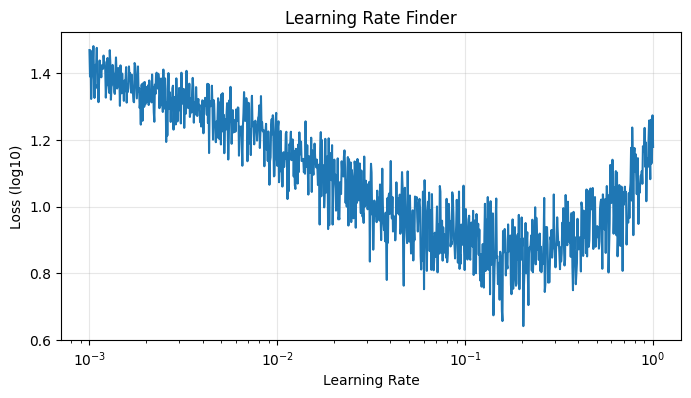

In [47]:
# Plot loss vs learning rate — look for the "sweet spot" where loss drops fastest
plt.figure(figsize=(8, 4))
plt.plot(lri, lossi)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss (log10)')
plt.title('Learning Rate Finder')
plt.grid(True, alpha=0.3)
plt.show()

# The optimal region is typically where the curve is steepest (before it starts going back up).
# For this model, its around LR = 0.1

## Why Exponential Spacing for the LR Sweep?

Notice we used `10 ** torch.linspace(-3, 0, 1000)` instead of `torch.linspace(0.001, 1.0, 1000)`. The key insight is that **learning rate sensitivity is multiplicative, not additive.**

Think of it this way: doubling the learning rate from 0.001 → 0.002 has roughly the same effect on training dynamics as doubling it from 0.1 → 0.2. What matters isn't the absolute change (0.001 vs 0.1), it's the **ratio** (both are 2x). This is because the learning rate scales the gradient update multiplicatively — `param -= lr * grad` — so what determines the step size relative to the current parameter values is the _factor_ by which you change the LR.

With a **linear** sweep from 0.001 to 1.0:

- The range [0.001, 0.01] (a 10x span) gets only ~1% of the steps
- The range [0.5, 1.0] (a 2x span) gets ~50% of the steps
- Almost all our budget is wasted in the high-LR region where the model is already diverging

With an **exponential** sweep (`10 ** linspace(-3, 0)`):

- [0.001, 0.01] gets ~33% of the steps
- [0.01, 0.1] gets ~33% of the steps
- [0.1, 1.0] gets ~33% of the steps
- Each **order of magnitude** gets equal exploration — which matches how LRs actually matter

**General principle:** Whenever a parameter spans multiple orders of magnitude and its effect is multiplicative (learning rate, weight decay, regularization strength), search in **log space**. This is why hyperparameter tuning frameworks (Optuna, Ray Tune) default to log-uniform sampling for these parameters.


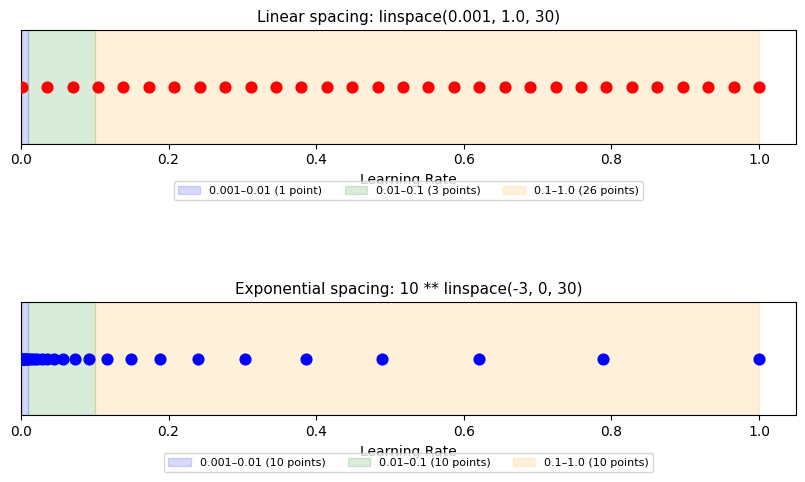

In [50]:
# Visual comparison: linear vs exponential LR spacing
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(10, 5), gridspec_kw={'hspace': 1.4})

n_points = 30  # use fewer points so the clustering is obvious

# Linear spacing
linear_lrs = np.linspace(0.001, 1.0, n_points)
axes[0].scatter(linear_lrs, [0]*n_points, s=60, c='red', zorder=5)
axes[0].set_xlim(0, 1.05)
axes[0].set_yticks([])
axes[0].set_title('Linear spacing: linspace(0.001, 1.0, 30)', fontsize=11)
axes[0].axvspan(0.001, 0.01, alpha=0.15, color='blue', label='0.001–0.01 (1 point)')
axes[0].axvspan(0.01, 0.1, alpha=0.15, color='green', label='0.01–0.1 (3 points)')
axes[0].axvspan(0.1, 1.0, alpha=0.15, color='orange', label='0.1–1.0 (26 points)')
axes[0].legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, -0.55), ncol=3)
axes[0].set_xlabel('Learning Rate')

# Exponential spacing
exp_lrs = 10 ** np.linspace(-3, 0, n_points)
axes[1].scatter(exp_lrs, [0]*n_points, s=60, c='blue', zorder=5)
axes[1].set_xlim(0, 1.05)
axes[1].set_yticks([])
axes[1].set_title('Exponential spacing: 10 ** linspace(-3, 0, 30)', fontsize=11)
n1_exp = np.sum((exp_lrs >= 0.001) & (exp_lrs < 0.01))
n2_exp = np.sum((exp_lrs >= 0.01) & (exp_lrs < 0.1))
n3_exp = np.sum((exp_lrs >= 0.1) & (exp_lrs <= 1.0))
axes[1].axvspan(0.001, 0.01, alpha=0.15, color='blue', label=f'0.001–0.01 ({n1_exp} points)')
axes[1].axvspan(0.01, 0.1, alpha=0.15, color='green', label=f'0.01–0.1 ({n2_exp} points)')
axes[1].axvspan(0.1, 1.0, alpha=0.15, color='orange', label=f'0.1–1.0 ({n3_exp} points)')
axes[1].legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, -0.55), ncol=3)
axes[1].set_xlabel('Learning Rate')

plt.show()

# The linear plot wastes almost all its points in the [0.1, 1.0] range.
# The exponential plot spreads points evenly across ALL orders of magnitude.

In [51]:
# Now train for real with the learning rate we found

# Re-initialize parameters for a clean training run
g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, embed_dim),            generator=g)
W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

for i in range(200000):
    # Mini-batch: randomly sample 32 examples
    ixds = torch.randint(0, Xtr.shape[0], (32,))
    mini_batch_inp, mini_batch_target = Xtr[ixds], Ytr[ixds]

    # Forward pass
    emb = C[mini_batch_inp]                                        # (32, 3, 10)
    h = torch.tanh(emb.view(-1, embed_dim * block_size) @ W1 + b1)  # (32, 200)
    logits = h @ W2 + b2                                           # (32, 27)
    loss = F.cross_entropy(logits, mini_batch_target)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Learning rate step decay: 0.1 for first 100K steps, then 0.01
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track loss
    stepi.append(i)
    lossi.append(loss.log10().item())

print(f"Final training loss (last batch): {loss.item():.4f}")

Final training loss (last batch): 1.9606


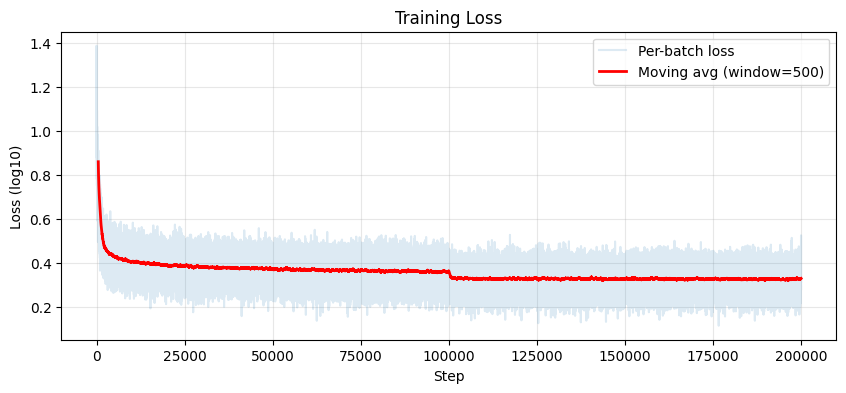

In [53]:
# Plot training loss over time
plt.figure(figsize=(10, 4))
plt.plot(stepi, lossi, alpha=0.15, color='tab:blue', label='Per-batch loss')

# Moving average (window of 500 steps) to show the trend clearly
window = 500
moving_avg = torch.tensor(lossi).unfold(0, window, 1).mean(dim=1)
plt.plot(stepi[window-1:], moving_avg, color='red', linewidth=2, label=f'Moving avg (window={window})')

plt.xlabel('Step')
plt.ylabel('Loss (log10)')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# You can see the loss drop quickly in the first few thousand steps,
# then gradually improve. The jump at step 100K is when we reduce the LR from 0.1 to 0.01.

## The Learning Rate Drop at Step 100K

Look at the moving average around step 100,000 — there's a noticeable **downward jump** in loss. That's exactly where we switched from `lr=0.1` to `lr=0.01`. But why does _reducing_ the learning rate cause the loss to suddenly improve?

**The intuition:** Think of the loss landscape as a valley. With a large learning rate, each gradient step takes a big leap — big enough to overshoot the bottom of the valley and land on the opposite slope. The model keeps bouncing back and forth _across_ the valley floor, never settling into the lowest point. It makes fast progress toward the valley (the early rapid loss drop), but once it's in the right neighborhood, the large steps prevent it from settling down.

When we cut the learning rate by 10x, the steps become much smaller. The model stops overshooting and can finally descend into the narrow bottom of the valley. That's the sudden drop — the model was already _near_ a good solution, but the large learning rate was keeping it from reaching it.

This is also why the loss curve looks **less noisy** after 100K steps. With `lr=0.1`, each mini-batch gradient pushes the parameters a lot (high variance in the loss). With `lr=0.01`, the same gradients produce much smaller updates, so the loss fluctuates less from batch to batch.

**From manual step decay to real LR schedulers:** Our approach — "use 0.1 for 100K steps, then switch to 0.01" — is the simplest possible learning rate schedule, and it works, but it requires manually choosing both the LR values and the switchover point. In practice, PyTorch provides schedulers that automate this:

| Scheduler           | Strategy                                                   | When to use                                                            |
| :------------------ | :--------------------------------------------------------- | :--------------------------------------------------------------------- |
| `StepLR`            | Multiply LR by a factor every N epochs                     | What we're doing here, but automated                                   |
| `CosineAnnealingLR` | Smoothly decay LR following a cosine curve from max to min | The most popular choice for training transformers (used in GPT, LLaMA) |
| `ReduceLROnPlateau` | Watch val loss; reduce LR when it stops improving          | Good when you don't know how many steps you need                       |
| `OneCycleLR`        | Ramp LR up then back down over training (warm-up + decay)  | Often gives the fastest convergence for a fixed budget                 |

The cosine schedule is worth highlighting — instead of a hard jump from 0.1 to 0.01, it smoothly decreases the LR over the entire training run following a cosine curve. This avoids the "wasted bouncing" period entirely and tends to produce better results. Nearly every modern LLM training run uses cosine annealing (sometimes with a linear warm-up phase at the start).


## How Did We Do?

For comparison, the bigram model from lesson 2 achieved a loss of **~2.45** — that was the best a model could do with only one character of context. Our MLP, with 3 characters of context and ~11K learned parameters, should do noticeably better (**~2.1–2.3**) thanks to the richer context window.

**Overfitting check:** If the training loss is significantly lower than the validation loss, the model is memorizing the training data rather than learning generalizable patterns. In that case, we'd want to reduce model capacity (smaller `n_hidden` or `embed_dim`) or add regularization. A small gap is normal and expected — the model has literally seen the training data during optimization — but a large gap means we're overfitting.


In [55]:
# Evaluate on both training and validation sets (full dataset, not mini-batches)

@torch.no_grad()
def eval_loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(-1, embed_dim * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

train_loss = eval_loss(Xtr, Ytr)
val_loss = eval_loss(Xdev, Ydev)
print(f"Training loss:   {train_loss:.4f}")
print(f"Validation loss: {val_loss:.4f}")

Training loss:   2.1281
Validation loss: 2.1718


# Section 7: Visualizing the Embeddings

One of the most beautiful aspects of learned embeddings is that they organize themselves meaningfully without any explicit supervision. The model was never told that `a`, `e`, `i`, `o`, `u` are vowels — it discovered this implicitly from the data, because vowels tend to appear in similar contexts (between consonants, often interchangeable).

To visualize this, we'll train a model with `embed_dim=2` so each character's embedding is just a 2D point we can plot on a scatter plot. With higher-dimensional embeddings, you'd need dimensionality reduction (PCA, t-SNE) to visualize, but 2D lets us see the raw learned space directly.


In [56]:
# Train a 2D embedding model specifically for visualization
embed_dim_viz = 2
n_hidden_viz = 200

g = torch.Generator().manual_seed(2147483647)
C_viz  = torch.randn((vocab_size, embed_dim_viz),                generator=g)
W1_viz = torch.randn((embed_dim_viz * block_size, n_hidden_viz), generator=g)
b1_viz = torch.randn(n_hidden_viz,                            generator=g)
W2_viz = torch.randn((n_hidden_viz, vocab_size),              generator=g)
b2_viz = torch.randn(vocab_size,                              generator=g)
parameters_viz = [C_viz, W1_viz, b1_viz, W2_viz, b2_viz]
for p in parameters_viz:
    p.requires_grad = True

# Train for 200K steps (same schedule)
for i in range(200000):
    ixds = torch.randint(0, Xtr.shape[0], (32,))
    mini_batch_inp, mini_batch_target = Xtr[ixds], Ytr[ixds]

    emb = C_viz[mini_batch_inp]
    h = torch.tanh(emb.view(-1, embed_dim_viz * block_size) @ W1_viz + b1_viz)
    logits = h @ W2_viz + b2_viz
    loss = F.cross_entropy(logits, mini_batch_target)
    for p in parameters_viz:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters_viz:
        p.data += -lr * p.grad

print(f"2D model final loss: {loss.item():.4f}")

2D model final loss: 2.3008


In [60]:
# Evaluate on both training and validation sets (full dataset, not mini-batches)

@torch.no_grad()
def eval_loss(X, Y):
    emb = C_viz[X]
    h = torch.tanh(emb.view(-1, embed_dim_viz * block_size) @ W1_viz + b1_viz)
    logits = h @ W2_viz + b2_viz
    loss = F.cross_entropy(logits, Y)
    return loss.item()

train_loss = eval_loss(Xtr, Ytr)
val_loss = eval_loss(Xdev, Ydev)
print(f"Training loss:   {train_loss:.4f}")
print(f"Validation loss: {val_loss:.4f}")

Training loss:   2.2326
Validation loss: 2.2430


Notice how this `embed_dim=2` model is doing _worse_ than the `embed_dim=10` model.


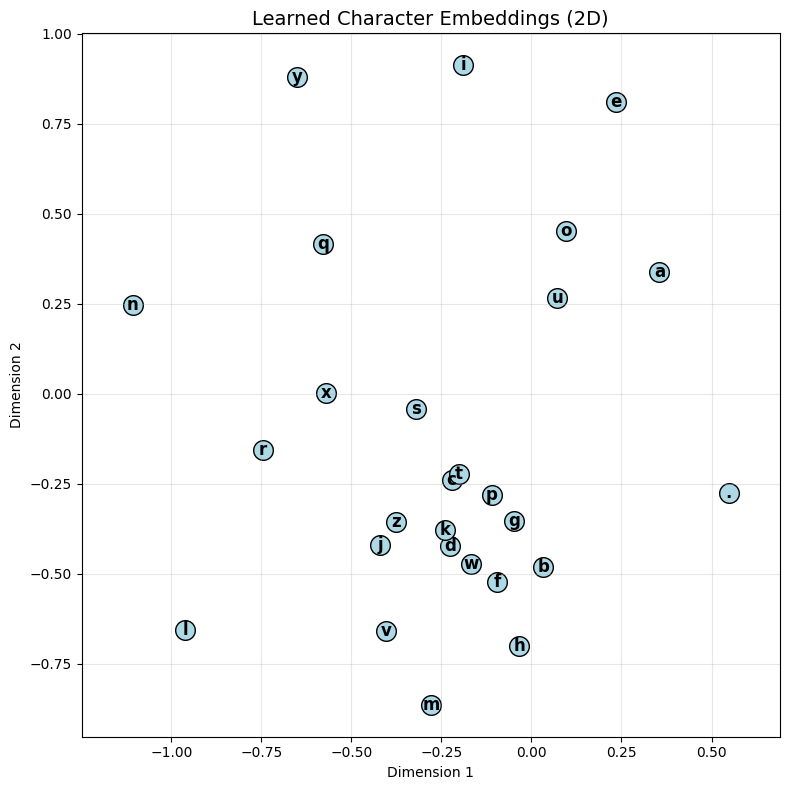

In [65]:
# Scatter plot of the 2D character embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C_viz[:, 0].data, C_viz[:, 1].data, s=200, c='lightblue', edgecolors='black')
for i in range(vocab_size):
    plt.annotate(itos[i], (C_viz[i, 0].item(), C_viz[i, 1].item()),
                 ha='center', va='center', fontsize=12, fontweight='bold')
plt.title('Learned Character Embeddings (2D)', fontsize=14)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## What Structure Can We See?

Look at the scatter plot and notice how the model has organized the characters:

- **Vowels** (`a`, `e`, `i`, `o`, `u`) tend to cluster together — the model learned that these characters are interchangeable in many contexts (e.g., `dan`, `den`, `din`, `don`, `dun` are all plausible name fragments), so it placed them nearby in embedding space.
- **The special token `.`** is usually off on its own, far from the letters. This makes sense — `.` behaves completely differently from any letter (it marks boundaries, not sounds).
- **Consonants that appear in similar contexts** may end up nearby.

The exact layout will change with different random seeds (the embedding space has rotational symmetry — there's no "correct" orientation), but the **clustering structure is consistent**. The model reliably discovers vowel/consonant groupings because that's the structure that helps it predict the next character most accurately.

This is the power of learned embeddings in action — the model was never told any phonetics or linguistics. It figured out that certain characters are functionally similar purely from the statistical patterns in 32K names.

**Why one-hot encoding could never do this:** With one-hot vectors, every character is equidistant from every other character — `a` is just as far from `e` (another vowel) as it is from `z` (a rare consonant). The distance between any two one-hot vectors is always the same (`sqrt(2)`). There's no notion of similarity, no clustering, no structure at all. If the model sees `dan` in training, it learns nothing about `den` because `a` and `e` are completely unrelated vectors.

Learned embeddings fix this by letting the model **compress** the 27-dimensional one-hot space down to just 2 (or 10) dimensions, and in doing so, it's _forced_ to place similar characters nearby. This is why the model generalizes — when it learns something about one vowel, that knowledge automatically transfers to other vowels because they share similar embedding vectors. This is exactly what Bengio meant by "shared statistical strength" in the original paper.


# Section 8: Sampling from the Model

Sampling from our MLP works the same way as the bigram model — **autoregressive generation**. We start with a context of all dots (`...`), predict a probability distribution over the next character, sample from it, shift the context window, and repeat until we sample a dot (end-of-name).

The key difference from bigrams: because we're using 3 characters of context instead of 1, the generated names should sound much more plausible. The model can learn patterns like "consonant clusters that are common at the start of names" or "vowel patterns that are typical in the middle".


In [66]:
# Generate names from the trained model (the 10D model, not the 2D visualization model)
g = torch.Generator().manual_seed(2147483647 + 10)

print("Generated names:")
print("-" * 20)
for _ in range(20):
    out = []
    context = [0] * block_size # start with '...'
    while True:
        # Forward pass on the current context
        emb = C[torch.tensor([context])] # (1, block_size, embed_dim)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # Sample next character from the predicted distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # Shift context window and append the sampled character
        context = context[1:] + [ix]

        if ix == 0: # sampled the end token
            break
        out.append(itos[ix])

    print(''.join(out))

Generated names:
--------------------
carmah
amille
khirmyn
rehton
kanden
jazhuel
delynn
jareen
nellara
chaiif
kaleigh
ham
joce
quint
sulio
alianni
wanelo
dearynn
jace
pirsly


# Section 9: Hyperparameter Exploration

The model we've built has several hyperparameters that affect its performance. Understanding their trade-offs is a key part of ML engineering:

| Hyperparameter | Our Value | Effect of Increasing                                                      |
| :------------- | :-------: | :------------------------------------------------------------------------ |
| `embed_dim`    |    10     | Richer character representations, but more parameters in C and W1         |
| `n_hidden`     |    200    | More expressive hidden layer, but more parameters and risk of overfitting |
| `block_size`   |     3     | More context for prediction, but larger W1 and more data needed           |
| Learning rate  | 0.1→0.01  | Faster learning vs. stability; too high → divergence, too low → slow      |
| Batch size     |    32     | Larger → more stable gradients but slower per-step; smaller → more noise  |
| Training steps |   200K    | More steps → better convergence, but diminishing returns                  |

**The overfitting sweet spot:** With ~11K parameters and ~180K training examples, our model is relatively safe from severe overfitting (roughly 16 examples per parameter). But if we made the model much larger (e.g., `n_hidden=1000`), we'd need to watch the train/val gap carefully.

**What's next:** In Part 3, Karpathy addresses two critical issues we've glossed over here:

1. **Initialization** — our random init can cause the tanh to saturate and loss to start very high. Proper initialization (like Kaiming/He init) fixes this.
2. **Batch normalization** — a technique that stabilizes training by normalizing activations within each layer, making the model less sensitive to initialization and learning rate choices.


In [69]:
# Quick experiment cell — adjust hyperparameters and re-train to see the effect
# Try changing these values and running this cell + the next one

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

def train_model(embed_dim=10, n_hidden=200, block_size=3, lr=0.1, lr_decay=0.01,
                decay_at=100000, steps=200000, batch_size=32, seed=2147483647):
    """Train an MLP with the given hyperparameters and return train/val loss."""
    # Rebuild datasets with the given block_size, move to GPU
    Xtr_, Ytr_ = build_dataset(words[:n1], block_size)
    Xdev_, Ydev_ = build_dataset(words[n1:n2], block_size)
    Xtr_, Ytr_ = Xtr_.to(device), Ytr_.to(device)
    Xdev_, Ydev_ = Xdev_.to(device), Ydev_.to(device)

    g = torch.Generator(device=device).manual_seed(seed)
    C  = torch.randn((vocab_size, embed_dim),            generator=g, device=device)
    W1 = torch.randn((embed_dim * block_size, n_hidden), generator=g, device=device)
    b1 = torch.randn(n_hidden,                           generator=g, device=device)
    W2 = torch.randn((n_hidden, vocab_size),             generator=g, device=device)
    b2 = torch.randn(vocab_size,                         generator=g, device=device)
    params = [C, W1, b1, W2, b2]
    for p in params:
        p.requires_grad = True

    for i in range(steps):
        ixds = torch.randint(0, Xtr_.shape[0], (batch_size,), device=device)
        mini_batch_inp, mini_batch_target = Xtr_[ixds], Ytr_[ixds]

        emb = C[mini_batch_inp]
        h = torch.tanh(emb.view(-1, embed_dim * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, mini_batch_target)
        for p in params:
            p.grad = None
        loss.backward()
        cur_lr = lr if i < decay_at else lr_decay
        for p in params:
            p.data += -cur_lr * p.grad

    # Evaluate
    with torch.no_grad():
        emb = C[Xtr_]
        h = torch.tanh(emb.view(-1, embed_dim * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        train_loss = F.cross_entropy(logits, Ytr_).item()

        emb = C[Xdev_]
        h = torch.tanh(emb.view(-1, embed_dim * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        val_loss = F.cross_entropy(logits, Ydev_).item()

    total_params = sum(p.nelement() for p in params)
    print(f"embed_dim={embed_dim}, n_hidden={n_hidden}, block_size={block_size}, "
          f"params={total_params:,}, train={train_loss:.4f}, val={val_loss:.4f}")
    return train_loss, val_loss

# Example: compare different embedding sizes
print("Comparing embedding sizes (this will take a minute)...")
for ne in [2, 5, 10]:
    train_model(embed_dim=ne, batch_size=4096)

Using device: cuda
Comparing embedding sizes (this will take a minute)...
embed_dim=2, n_hidden=200, block_size=3, params=6,881, train=2.2535, val=2.2595
embed_dim=5, n_hidden=200, block_size=3, params=8,762, train=2.1836, val=2.1970
embed_dim=10, n_hidden=200, block_size=3, params=11,897, train=2.1356, val=2.1644


## Automated Hyperparameter Tuning with Optuna

Manually tweaking `embed_dim`, `n_hidden`, and learning rate one-at-a-time is tedious and misses interactions between hyperparameters (e.g., a larger model might need a smaller learning rate). This is exactly the problem that **hyperparameter tuning libraries** solve.

[Optuna](https://optuna.org/) is the most popular choice in the PyTorch ecosystem. The idea is simple:

1. Define an **objective function** that takes a `trial` object, samples hyperparameters from it, trains the model, and returns the validation loss.
2. Optuna runs many trials, using **Bayesian optimization** (specifically, Tree-structured Parzen Estimators / TPE) to intelligently explore the search space — it learns from previous trials which regions are promising and focuses there, rather than searching randomly.
3. After the study completes, you get the best hyperparameters found.

Notice how Optuna uses `trial.suggest_int` and `trial.suggest_float(..., log=True)` — that `log=True` for the learning rate is the same log-space principle we discussed in the LR sweep section. Optuna knows that learning rates should be sampled logarithmically.


In [7]:
import optuna
import importlib
import sklearn
importlib.reload(optuna)
importlib.reload(sklearn)

optuna.logging.set_verbosity(optuna.logging.WARNING)  # suppress per-trial logs
print(sklearn.__version__)

1.8.0


In [14]:
def objective(trial):
    # Optuna suggests hyperparameters from the search space
    ed = trial.suggest_int('embed_dim', 2, 15)
    nh = trial.suggest_int('n_hidden', 50, 300, step=50)
    lr_start = trial.suggest_float('lr', 0.01, 0.5, log=True)  # log-uniform!
    lr_end = trial.suggest_float('lr_decay', 0.001, 0.05, log=True)
    bs = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Build datasets and initialize parameters
    Xtr_, Ytr_ = build_dataset(words[:n1], block_size)
    Xdev_, Ydev_ = build_dataset(words[n1:n2], block_size)

    g = torch.Generator().manual_seed(2147483647)
    C_  = torch.randn((vocab_size, ed),            generator=g, requires_grad=True)
    W1_ = torch.randn((ed * block_size, nh),       generator=g, requires_grad=True)
    b1_ = torch.randn(nh,                          generator=g, requires_grad=True)
    W2_ = torch.randn((nh, vocab_size),            generator=g, requires_grad=True)
    b2_ = torch.randn(vocab_size,                  generator=g, requires_grad=True)
    params = [C_, W1_, b1_, W2_, b2_]

    # Train for fewer steps (speed over precision — we just need to rank hyperparameters)
    steps = 20000
    for i in range(steps):
        ixds = torch.randint(0, Xtr_.shape[0], (bs,))
        emb = C_[Xtr_[ixds]]
        h = torch.tanh(emb.view(-1, ed * block_size) @ W1_ + b1_)
        logits = h @ W2_ + b2_
        loss = F.cross_entropy(logits, Ytr_[ixds])
        for p in params:
            p.grad = None
        loss.backward()
        cur_lr = lr_start if i < steps // 2 else lr_end
        for p in params:
            p.data += -cur_lr * p.grad

    # Return validation loss (Optuna minimizes this)
    with torch.no_grad():
        emb = C_[Xdev_]
        h = torch.tanh(emb.view(-1, ed * block_size) @ W1_ + b1_)
        logits = h @ W2_ + b2_
        val_loss = F.cross_entropy(logits, Ydev_).item()
    return val_loss

# Run 20 trials — takes ~1 minute
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f"\nBest validation loss: {study.best_value:.4f}")
print(f"Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


Best validation loss: 2.1893
Best hyperparameters:
  embed_dim: 11
  n_hidden: 200
  lr: 0.48465327066190766
  lr_decay: 0.019970363921337272
  batch_size: 128


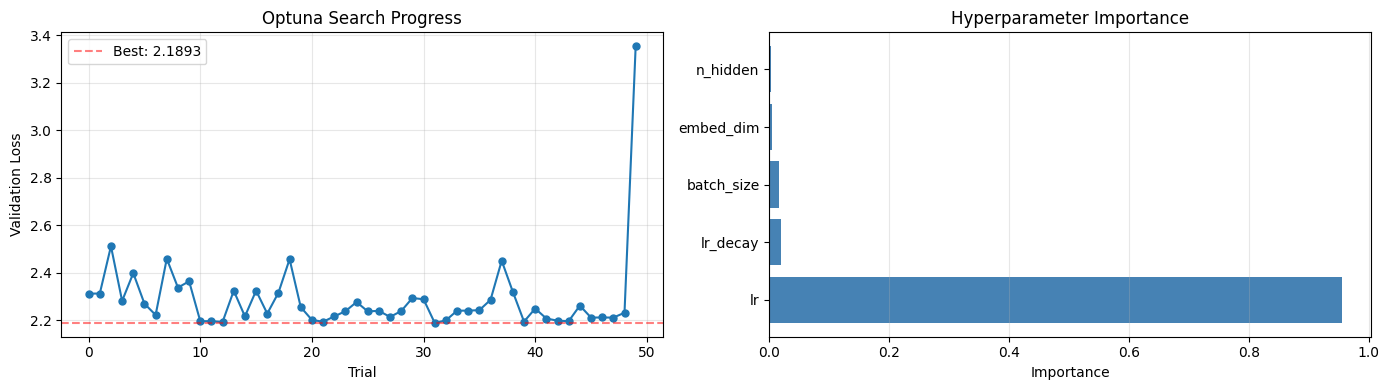

In [19]:
# Optuna tracks every trial — we can see how the search progressed
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: validation loss per trial (should trend downward as Optuna learns)
trials = study.trials
vals = [t.value for t in trials]
axes[0].plot(vals, 'o-', markersize=5)
axes[0].axhline(y=study.best_value, color='red', linestyle='--', alpha=0.5, label=f'Best: {study.best_value:.4f}')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Optuna Search Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: which hyperparameters matter most (importance)
importances = optuna.importance.get_param_importances(study)
axes[1].barh(list(importances.keys()), list(importances.values()), color='steelblue')
axes[1].set_xlabel('Importance')
axes[1].set_title('Hyperparameter Importance')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [20]:
importances

{'lr': np.float64(0.9562390530857257),
 'lr_decay': np.float64(0.019991035672454256),
 'batch_size': np.float64(0.016728547317546992),
 'embed_dim': np.float64(0.004529921470403016),
 'n_hidden': np.float64(0.002511442453870092)}

# Summary

In this notebook we implemented the core ideas from Bengio et al. 2003, building a character-level MLP that significantly outperforms the bigram model from lesson 2:

**What we built:**

- A **learned embedding table** that maps each character to a dense vector — the same concept behind `nn.Embedding` and transformer token embeddings
- A **fixed-context MLP** that takes 3 characters of context, embeds and concatenates them, passes through a hidden layer with tanh activation, and outputs a probability distribution over the next character
- **Mini-batch SGD training** with learning rate decay

**Key results:**

- Loss improved from ~2.45 (bigram) to ~2.17 (MLP) — a meaningful improvement from using more context
- The learned 2D embeddings show that the model discovers structure (vowel/consonant clustering) without supervision
- Generated names sound noticeably more plausible than bigram output

**Key concepts introduced:**

- Learned dense embeddings vs. one-hot encoding
- Train/validation/test splits and overfitting detection
- Mini-batch SGD and learning rate schedules
- The learning rate finder technique
- `F.cross_entropy` and why it's better than manual softmax + NLL

**Looking ahead to Part 3 (Activations & Gradients):** The model we built here works, but we were somewhat lucky with our initialization. In the next video, Karpathy will show that random initialization can cause serious problems:

- **tanh saturation** — if initial activations are too large, tanh outputs are all ±1 and gradients vanish
- **Dead neurons** — some hidden units may never activate usefully

The fix involves proper **weight initialization** (Kaiming/He init) and **batch normalization** — techniques that make training deep networks much more reliable. These are the same techniques used in production-scale models today.
